In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import datetime
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns


from numba import jit
from multiprocessing import cpu_count
from dask.multiprocessing import get

nCores = cpu_count()
sns.set()

## Initializing Data

The computer I primarily use has 32GB of RAM (DDR4-3200,CAS14).  Additionally, I created a 64GB swap file partition on a Samsung 960 Evo M.2 Flash Drive (if anyone has any experience using Intel Optane drive for this, let me know about your experiences).  I wanted to create a dataframe that exceeded 32GB in memory to test the efficacy of Pandas vs Dask vs Spark.  The following parameters should accomplish that with 100 million rows.

In [3]:
nRows = 100000
startdate = datetime.date(1900,1,1)
geoCenter = (40.723270, -73.988371)

The "data" contains a random date between 1900 and 2000, a random float between 0 and 1, a random int between 0 and 3333, a "categorical" string of [a-z], and two random geo points, one slightly off the other.

The random int column, c2, contains NaN values, 2% of the total.

The categorical column, c3, also contains NaN values, 2% of the total.

In [23]:
### initializing random data
data = pd.DataFrame({'date':[startdate + datetime.timedelta(int(i)) for i in np.random.randint(1,36524,size=nRows)],
                     'c1':np.random.rand(nRows),
                     'c2':np.random.randint(0,3333,nRows),
                     'c3':[random.choice(string.ascii_letters).lower() for i in range(nRows)],
                     'lat_1':np.random.rand(nRows) + geoCenter[0],
                     'lon_1':np.random.rand(nRows) + geoCenter[1]
                    })

data['lat_2'] = data['lat_1']
data['lon_2'] = data['lon_1'] + 0.003

data.date = pd.to_datetime(data.date)

### picking random null values
data.loc[data.sample(frac=.02).index,'c2'] = np.nan
data.loc[data.sample(frac=.02).index,'c3'] = np.nan

In [24]:
data.to_feather('/tmp/data')

In [39]:
data = pd.read_feather('/tmp/data')

## Data Pre-Processing Steps

### Dates

In column `date` we have datetime objects as if they had been parsed by pandas `read_csv` with `parse_dates`.  These are YYYY-MM-DD style, with no additional time information.

In most machine learning algorithims, we would want to separate out the individual components of a date into their own feature.  For this date, we will create five features: the year, month, week, day, and day of the week.

### Filling Missing Values

For missing values in column `c2` we're going to impute the mean value.  Additionally, we're going to create a new feature `c2_isnull` so that our models will be able to, hopefully, pick up on the fact that value is artificial.

We'll deal with the missing values in column `c3` when we encode these strings into integers.

### Encoding Categorical Variables

Scikit-learn comes with a `LabelEncoder` but we'll be using one from scratch.  Unfortunately, scikit-learn's encoder does not play well with new/missing values.  

We know that column `c3` contains letters `a-z`, but let's say that in our train-test split, our training set was missing the letter `z`.  `LabelEncoder` throws an error when attempting to encode `z` in our test set.  Instead, we would rather a separate value be encoded, like `-1`, to signify that the true encoding is unknown.  Likewise, since this column contains missing values, we would also impute `-1` for nulls in our training and test set.

## Python, Pandas, Single-Processor

The following function extracts the various parts of time from a datetime column and returns the original dataframe with the new features:

In [35]:
### input: dataframe, column of datetime objects, desired list of time-interval features
### output: dataframe with new time-interval features appended
def date_extractor(df, dateCol, interval=['year','month','week','day','dayofweek']):
    df.is_copy = False # we're not dealing with copies, this avoids the warning
    for i in interval:
        df.loc[:,i] = eval('df.%s.dt.%s'% (dateCol,i))
        
    return df

This next function fills our missing values and creates an addition feature: `feat_isnull`

In [36]:
### input: dataframe, numerical columns with null values
### output: dataframe with null values imputed with median and a new feature indicating that entry was null
def impute_null(df, cols):
    for col in cols:
        # creating the new feature which indicates isnull
        feat_is_null = col + '_isnull'
        df.loc[:,feat_is_null] = np.int8(df[col].isnull())
        
         # imputing median
        impute_value = np.nanmedian(df[col])
        df.loc[:,col].fillna(impute_value, inplace=True)

For categorical features, we'll treat them slightly differently.

In [ ]:
### input: dataframe, categorical column with null values
### output: dataframe with null values imputed with 'UNK' and a new feature indicating entry was null
def impute_null_cat(df, cols):
    for col in cols:
        # creating the new feature which indicates isnull
        feat_is_null = col + '_isnull'
        df.loc[:,feat_is_null] = np.int8(df[col].isnull())
        
        # imputing missing code
        df.loc[:,col].fillna('UNK', inplace=True)

In [13]:
results_dates = pd.DataFrame({'pandas':[],
                              'nRows':[]
                             })

for i,nIter in enumerate(10 ** np.arange(0,7)): 
    print('Size: %s'% nIter)
    out1_ = %timeit -n 1 -r 3 -o _ = date_extractor(data.head(nIter),'date')
    row = {'pandas':out1_.average,
           'nRows':nIter
          }
    results_dates.loc[i] = row

Size: 1
9.75 ms ± 910 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 10
7.12 ms ± 933 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 100
5.84 ms ± 399 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 1000
5.61 ms ± 120 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 10000
8.73 ms ± 332 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 100000
48.3 ms ± 2.57 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Size: 1000000
45.8 ms ± 179 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


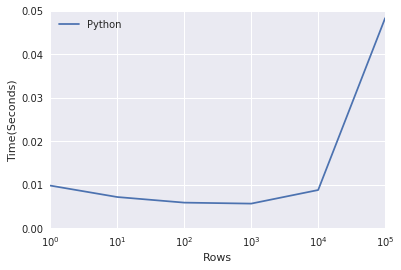

In [16]:
fig, ax = plt.subplots()
ax.plot((results_dates.nRows), results_dates.pandas, label='Python')
ax.set_xlabel("Rows")
ax.set_ylabel("Time(Seconds)")
ax.set_xscale('log')
ax.axis([1,100000,0,.05])
ax.legend()
#fig.savefig('./python_numba_only.png',dpi=300)

In [ ]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setMaster('local[*]').setAppName('parallel_preprocessing')
sc = SparkContext.getOrCreate(conf=conf)